# 3D Objects Recognition

#### Neural Network for Suggestive CAD

--------------------------------------------------------------------------------------------------------------------------------

    Import packages

In [ ]:
import numpy
import collections
from tensorflow.python.framework import dtypes

from os import listdir
import os
from os.path import isfile, join
import numpy as np
import cv2

import matplotlib.pylab as plt
%matplotlib inline

from __future__ import division
from __future__ import print_function

import argparse
import sys

import glob
import param
import time

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import IPython.display as display

import tensorflow as tf

import pydotplus as pydot
import graphviz

In [ ]:
###From https://gist.github.com/ambodi/408301bc5bc07bc5afa8748513ab9477#file-dataset-py-L74

In [3]:
###Data from  https://www.kaggle.com/c/dogs-vs-cats/data

## Saving raw data to npy

#### Load data

In [46]:
#path to directory
path_train = 'raw_data/train/'
path_test = 'raw_data/test/'
img_size= 100

#get folder names
def directory_scan(path):
    dirlist = [ item for item in os.listdir(path) if os.path.isdir(os.path.join(path, item)) ]
    return dirlist

#build labels and image arrays, resize image to 100*100
def read_images_in_folder(dirlist, path):
    images=[]
    labels = []
    count = 0
    for i in range(len(dirlist)):
        image_stack = []
        for img in glob.glob(path+dirlist[i]+'/*jpg'):
            count=count+1
            labels.append(dirlist[i])
            IMG = cv2.imread(img)
            #RGB to grey scale
            IMG_2= cv2.cvtColor( IMG, cv2.COLOR_RGB2GRAY )
            #resize to 100*100
            im_resize = cv2.resize(IMG_2, (img_size, img_size), interpolation=cv2.INTER_CUBIC)
            images.append(im_resize)
        #np_images = np.array(image_stack)
        
    return images, labels, count

if __name__ == '__main__':
    dirlist_train = directory_scan(path_train)
    images_train,labels_train,count_train = read_images_in_folder(dirlist_train, path_train)
    dirlist_test = directory_scan(path_test)
    images_test,labels_test,count_test = read_images_in_folder(dirlist_test, path_test)

#save to file
np.save('npy/images_train',images_train)
np.save('npy/labels_train',labels_train)
np.save('npy/images_test',images_test)
np.save('npy/labels_test',labels_test)

print('There are '+ str(count_train) +' training images')
print('There are '+ str(count_test) +' testing images')

nb_img_train = count_train
nb_img_test = count_test

There are 15008 training images
There are 1120 testing images


#### Load NPY data

In [2]:
#LOAD TRAIN
#load images
train_images = np.load('npy/images_train.npy')

#load labels
train_labels = np.load('npy/labels_train.npy')

#LOAD TEST
#load images
test_images = np.load('npy/images_test.npy')

#load labels
test_labels = np.load('npy/labels_test.npy')

img_size=100

bed


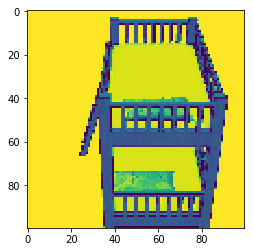

In [3]:
index = 50
print(train_labels[index])
plt.imshow(train_images[index])

In [4]:
path_train = 'raw_data/train/'
path_test = 'raw_data/test/'
img_size= 100

#get folder names
def directory_scan(path):
    dirlist = [ item for item in os.listdir(path) if os.path.isdir(os.path.join(path, item)) ]
    return dirlist

dirlist_train = directory_scan(path_train)
dirlist_test = directory_scan(path_test)

nb_img_train = len(train_images)
nb_img_test = len(test_images)

In [5]:
#prepare and reshape testing/training sets
#img_size = 100
#nb_img_train = 1400
#nb_img_test = 40

train_img = train_images.reshape((nb_img_train, img_size * img_size))
train_img = train_img.astype('float32') / 255

test_img = test_images.reshape([-1,img_size,img_size,1])
test_img = test_img.astype('float32') / 255

#### One Hot Encoding of Labels

In [6]:
#LABEL ONE HOT ENCODING
#Training
k=0
for i in range(len(dirlist_train)):
    for j in range(len(train_labels)):
        if(train_labels[j]==dirlist_train[i]):
            train_labels[j]=k
    k=k+1

#Testing
m=0
for l in range(len(dirlist_test)):
    for h in range(len(test_labels)):
        if(test_labels[h]==dirlist_test[l]):
            test_labels[h]=m
    m=m+1

In [29]:
from keras import models
from keras import layers

from keras.utils import to_categorical

from keras.layers import Dense, Dropout, Activation

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.callbacks import History 

train_lab= to_categorical(train_labels)
test_lab = to_categorical(test_labels)

def Plot_accuracy(train_acc, Title):
    x = [i for i in range(0, len(train_acc))]
    y= train_acc
    plt.plot(x,y)
    plt.ylabel('Accuracy')
    plt.xlabel('Steps')
    plt.xticks(x)
    plt.ylim(ymax=1)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.grid(True)
    plt.title(Title)
    plt.show()
    
def Plot_Loss(train_loss, Title):
    x = [i for i in range(0, len(train_loss))]
    y= train_loss
    plt.plot(x,y)
    plt.ylabel('Loss')
    plt.xlabel('Steps')
    plt.xticks(x)
    plt.ylim(ymax=2)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.grid(True)
    plt.title(Title)
    plt.show()

--------------------------------------------------------------------------------------------------------------------------------

## Neural Net Model

    Generate Computational Graph

In [129]:
#initializes the model
network = models.Sequential()

#BUILD COMPUTATIONAL GRAPH
network.add(layers.Dense(200, activation='relu', input_shape=(100 * 100,)))

network.add(layers.Dense(300, activation='relu'))

network.add(layers.Dense(400, activation='relu'))

network.add(layers.Dense(200, activation='relu'))

network.add(Dropout(0.7))

network.add(layers.Dense(300, activation='relu'))

network.add(Dropout(0.7))

network.add(layers.Dense(300, activation='relu'))

network.add(layers.Dense(len(dirlist_train), activation='softmax'))

In [44]:
#Load previous model weights
network.load_weights('saved_models/network_weights.h5', by_name=True)

In [130]:
#SETS PERFORMANCE METRICS

network.compile(optimizer='Adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

#SVG(model_to_dot(network).create(prog='dot', format='svg'))

#from keras.utils import plot_model
#plot_model(network, to_file='model.png')

    Train Model

Epoch 1/200
15008/15008 [==============================] - 5s 301us/step - loss: 2.1188 - acc: 0.1854
Epoch 2/200
15008/15008 [==============================] - 3s 207us/step - loss: 1.8986 - acc: 0.2350
Epoch 3/200
15008/15008 [==============================] - 3s 195us/step - loss: 1.7953 - acc: 0.3008
Epoch 4/200
15008/15008 [==============================] - 3s 197us/step - loss: 1.7241 - acc: 0.3565
Epoch 5/200
15008/15008 [==============================] - 3s 194us/step - loss: 1.6421 - acc: 0.4007
Epoch 6/200
15008/15008 [==============================] - 3s 197us/step - loss: 1.6055 - acc: 0.4216
Epoch 7/200
15008/15008 [==============================] - 3s 212us/step - loss: 1.5825 - acc: 0.4320
Epoch 8/200
15008/15008 [==============================] - 3s 200us/step - loss: 1.5269 - acc: 0.4589
Epoch 9/200
15008/15008 [==============================] - 3s 196us/step - loss: 1.4846 - acc: 0.4734
Epoch 10/200
15008/15008 [==============================] - 3s 194us/step - loss: 

15008/15008 [==============================] - 3s 184us/step - loss: 0.6303 - acc: 0.7936
Epoch 81/200
15008/15008 [==============================] - 3s 184us/step - loss: 0.7227 - acc: 0.7622
Epoch 82/200
15008/15008 [==============================] - 3s 188us/step - loss: 0.6200 - acc: 0.7922
Epoch 83/200
15008/15008 [==============================] - 3s 190us/step - loss: 0.5830 - acc: 0.8091
Epoch 84/200
15008/15008 [==============================] - 3s 184us/step - loss: 0.5699 - acc: 0.8148
Epoch 85/200
15008/15008 [==============================] - 3s 198us/step - loss: 0.5188 - acc: 0.8316
Epoch 86/200
15008/15008 [==============================] - 3s 193us/step - loss: 0.4800 - acc: 0.8426
Epoch 87/200
15008/15008 [==============================] - 3s 193us/step - loss: 0.5265 - acc: 0.8274
Epoch 88/200
15008/15008 [==============================] - 3s 207us/step - loss: 0.5555 - acc: 0.8187
Epoch 89/200
15008/15008 [==============================] - 3s 187us/step - loss: 0.53

15008/15008 [==============================] - 3s 194us/step - loss: 0.1914 - acc: 0.9398
Epoch 160/200
15008/15008 [==============================] - 3s 200us/step - loss: 0.2034 - acc: 0.9364
Epoch 161/200
15008/15008 [==============================] - 3s 190us/step - loss: 0.2435 - acc: 0.9220
Epoch 162/200
15008/15008 [==============================] - 3s 186us/step - loss: 0.3216 - acc: 0.9003
Epoch 163/200
15008/15008 [==============================] - 3s 186us/step - loss: 0.2731 - acc: 0.9122
Epoch 164/200
15008/15008 [==============================] - 3s 185us/step - loss: 0.2359 - acc: 0.9226
Epoch 165/200
15008/15008 [==============================] - 3s 195us/step - loss: 0.2391 - acc: 0.9231
Epoch 166/200
15008/15008 [==============================] - 3s 190us/step - loss: 0.1921 - acc: 0.9390
Epoch 167/200
15008/15008 [==============================] - 3s 187us/step - loss: 0.1812 - acc: 0.9432
Epoch 168/200
15008/15008 [==============================] - 3s 186us/step - l

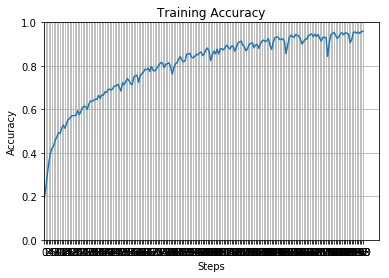

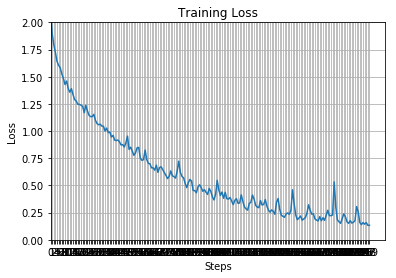

In [131]:
#Run model
#calculate running time
start = time.time()
history= History()

network.fit(train_img, train_lab, epochs=200, batch_size=800, shuffle=True, callbacks=[history])

stop = time.time()
print("Execution time = " + str(int(((stop-start)-(stop-start)%60)/60)) +" min "+str((stop-start)%60)+" sec")

Plot_accuracy(history.history['acc'], "Training Accuracy")

Plot_Loss(history.history['loss'], "Training Loss")

In [132]:
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 200)               2000200   
_________________________________________________________________
dense_51 (Dense)             (None, 300)               60300     
_________________________________________________________________
dense_52 (Dense)             (None, 400)               120400    
_________________________________________________________________
dense_53 (Dense)             (None, 200)               80200     
_________________________________________________________________
dropout_15 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 300)               60300     
_________________________________________________________________
dropout_16 (Dropout)         (None, 300)               0         
__________

    Run on Test Set

In [121]:
train_img = train_images.reshape((nb_img_train, img_size * img_size))
train_img = train_img.astype('float32') / 255

test_imgs = test_images.reshape([-1,img_size*img_size])
test_imgs = test_imgs.astype('float32') / 255

test_loss, test_acc = network.evaluate(test_imgs, test_lab)

1120/1120 [==============================] - 0s 136us/step


In [122]:
print('test_acc:', test_acc, 'test_loss', test_loss)

test_acc: 0.5705357142857143 test_loss 2.1687780014106206


    Predict for one image

 
Predicted Label : BED, Score:0.986019
Actual Label : BED
 
-----------------------------------------------------------
 
BED : 0.986019
CHAIR : 0.010899818
COUCH : 0.0022536914
LAMP : 0.0004481701
TABLE : 0.00023916371
CABINET : 0.0001227015
BENCH : 1.630489e-05
PLANT : 1.0669767e-06


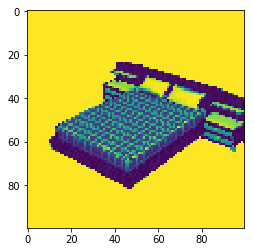

In [128]:
predictions = network.predict(test_imgs)

def Print_Pred(Predictions, index):
    
    scores = []

    for i in range(len(dirlist_train)):
        tup = (str(dirlist_train[i]), Predictions[index][i])
        #sorted(predictions[1])
        scores.append(tup)

    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    
    print(" ")
    print("Predicted Label : " + '\033[1m'  + str(max(scores, key=lambda x: x[1])[0]).upper() + '\033[0m'+ ", Score:" + '\033[1m'  +str(max(scores, key=lambda x: x[1])[1])+ '\033[0m' )
    for i in range(len(test_lab[index])):
        if(test_lab[index][i]== 1):
            actual_label = dirlist_test[i]
    print("Actual Label : " + '\033[1m'  +str(actual_label).upper()  + '\033[0m')
    print(" ")
    print("-----------------------------------------------------------")
    print(" ")
    
    plt.imshow(test_images[index])

    for i in range(len(sorted_scores)):
        print(str(sorted_scores[i][0]).upper()  + " : " +str(sorted_scores[i][1]))

#PRint prediction for given image
Print_Pred(predictions, 5)

    Save Model Weights

In [37]:
network.save_weights('saved_models/network_weights.h5')

--------------------------------------------------------------------------------------------------------------------------------

## Convolutional Model

In [10]:
# Learning Tensorflow, O'Reilly, Convolutional Neural Network, p. 63

#### Helper Function Defintion

In [54]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [55]:
#sets couple of functions
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial=tf.constant(0.1,shape=shape)
    return tf.Variable(initial)
    
def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME')

def conv_layer(input_,shape):
    W=weight_variable(shape)
    b=bias_variable([shape[3]])
    return tf.nn.relu(conv2d(input_,W)+b)

def full_layer(input_,size):
    in_size=int(input_.get_shape()[1])
    W=weight_variable([in_size,size])
    b= bias_variable([size])
    return tf.matmul(input_,W)+b

def Plot_accuracy(train_acc, Title):
    x = [i for i in range(0, len(train_acc))]
    y= train_acc
    plt.plot(x,y)
    plt.ylabel('Accuracy')
    plt.xlabel('Steps')
    plt.xticks(x)
    plt.ylim(ymax=1)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.grid(True)
    plt.title(Title)
    plt.show()

#### Computational Graph Definition

    Computational Graph Variables

In [57]:
nb_max2x2 = 2
kernel_size= 5
conv1_output = 100
conv2_output = 200
fully_connected_length = int(img_size/(2*nb_max2x2)*img_size/(2*nb_max2x2)*conv2_output)
fully_connected_1_output =500
dropout_ratio = 0.5

    Computational Graph

In [58]:
#Placeholders
x = tf.placeholder(tf.float32, shape=[None, img_size,img_size,1])
y_ = tf.placeholder(tf.float32, shape=[None,len(dirlist_train)])

#reshape images array
x_image = train_images.reshape([len(train_images) , img_size , img_size , 1])

#first conv layer
#INPUT images >> (len(train_images),100,100,1)
conv1= conv_layer(x, shape=[kernel_size,kernel_size,1,conv1_output ]) #shape [kernel height, kernel width, nb of chanels in images, nb of output layers]
conv1_pool= max_pool_2x2(conv1)
#OUTPUT images >> (100,50,50)

#second conv layer
#INPUT images >> (100,50,50)
conv2= conv_layer(conv1_pool, shape=[kernel_size , kernel_size , conv1_output , conv2_output])
conv2_pool= max_pool_2x2(conv2)
#OUTPUT images >> (200,25,25)

#second conv layer
#INPUT images >> (100,50,50)
#conv3= conv_layer(conv2_pool, shape=[kernel_size , kernel_size , conv2_output , conv2_output])
#conv3_pool= max_pool_2x2(conv3)
#OUTPUT images >> (200,25,25)

#second conv layer
#INPUT images >> (100,50,50)
#conv4= conv_layer(conv3_pool, shape=[kernel_size , kernel_size , conv2_output , conv2_output])
#conv4_pool= max_pool_2x2(conv4)
#OUTPUT images >> (200,25,25)

#fully connected layer
#INPUT images >> (200,25,25) >> reshape to 200*25*25 >> 125000
conv2_flat = tf.reshape(conv2_pool, [-1,fully_connected_length])
full_1 = tf.nn.relu(full_layer(conv2_flat, fully_connected_1_output))
#OUTPUT images >> (-1,1000)

#dropout layer
keep_prob=tf.placeholder(tf.float32)
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, len(dirlist_train))

    Run Variables

In [60]:
#Run Variables
batch_size=50
STEPS= 5

    Run

step 0, training accuracy 0.019999999552965164
step 1, training accuracy 0.20000000298023224
step 2, training accuracy 0.2199999988079071
step 3, training accuracy 0.23999999463558197
step 4, training accuracy 0.18000000715255737
test accuracy: 0.1339285671710968


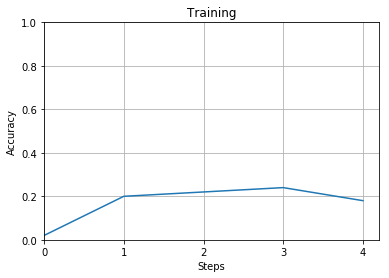

Execution time = 1 min 26.5264573097229 sec


In [61]:
train_acc = []

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_conv, labels = y_))

train_step = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#calculate running time
start = time.time()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(STEPS):
        
        batch_img, batch_label = next_batch(batch_size,x_image,train_lab)
        
        if i%1==0:
            train_accuracy = sess.run(accuracy, feed_dict={x: batch_img, y_: batch_label, keep_prob: 1.0})
            print("step {}, training accuracy {}".format(i, train_accuracy))
            train_acc.append(train_accuracy)
            
        sess.run(train_step, feed_dict={x: batch_img, y_: batch_label, keep_prob: dropout_ratio})
        
    X = test_img
    Y = test_lab
    test_accuracy = np.mean([sess.run(accuracy, feed_dict={x:X , y_:Y, keep_prob: 1.0})]) #for i in range(len(dirlist_train))])

#calculate running time
stop = time.time()

#Extract performance metrics
print('test accuracy: {}'.format(test_accuracy))
Plot_accuracy(train_acc, "Training Accuracy")
print("Execution time = " + str(int(((stop-start)-(stop-start)%60)/60)) +" min "+str((stop-start)%60)+" sec")